In [63]:
import functools
import os 
import numpy as np
import tensorflow as tf

from object_detection import inputs
from object_detection.core import preprocessor
from object_detection.core import standard_fields as fields

from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from utils import get_dataset

In [64]:
filepath = "data/waymo/training_and_validation/*.tfrecord"
dataset = get_dataset(filepath)

INFO:tensorflow:Reading unweighted datasets: ['data/waymo/training_and_validation/*.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['data/waymo/training_and_validation/*.tfrecord']
INFO:tensorflow:Number of filenames to read: 97


In [65]:
category_ind = {1: 'vehicle', 2: 'pedestrian', 3:'cyclist'}
class_color_ind = {1: '#FF0000', 2: '#0000FF', 4: '#00FF00'}

In [66]:
dataset.element_spec

{'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None),
 'source_id': TensorSpec(shape=(), dtype=tf.string, name=None),
 'key': TensorSpec(shape=(), dtype=tf.string, name=None),
 'filename': TensorSpec(shape=(), dtype=tf.string, name=None),
 'groundtruth_image_confidences': TensorSpec(shape=(None,), dtype=tf.float32, name=None),
 'groundtruth_verified_neg_classes': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
 'groundtruth_not_exhaustive_classes': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
 'groundtruth_boxes': TensorSpec(shape=(None, 4), dtype=tf.float32, name=None),
 'groundtruth_area': TensorSpec(shape=(None,), dtype=tf.float32, name=None),
 'groundtruth_is_crowd': TensorSpec(shape=(None,), dtype=tf.bool, name=None),
 'groundtruth_difficult': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
 'groundtruth_group_of': TensorSpec(shape=(None,), dtype=tf.bool, name=None),
 'groundtruth_weights': TensorSpec(shape=(None,), dtype=tf.float32, name=Non

In [67]:
for frame in dataset.shuffle(100).take(1):
    image = frame['image'].numpy()
    bboxes = frame['groundtruth_boxes'].numpy()
    classes = frame['groundtruth_classes'].numpy()

In [68]:
def display_instance_augmentation(image, bboxes, classes, augmentation, class_color_ind):
    data_augmentation_fn = functools.partial(
    inputs.augment_input_data,
    data_augmentation_options = augmentation)
    
    tensor_dict = {
        fields.InputDataFields.image: tf.constant(image.astype(np.float32)),
        fields.InputDataFields.groundtruth_boxes: tf.constant(bboxes.astype(np.float32)),
        fields.InputDataFields.groundtruth_classes: tf.constant(classes.astype(np.float32))
    }
    # apply augmentations
    augmented_tensor_dict = data_augmentation_fn(tensor_dict = tensor_dict)
    # augmentation output
    augmented_image = augmented_tensor_dict[fields.InputDataFields.image].numpy().astype(int)
    augmented_bboxes = augmented_tensor_dict[fields.InputDataFields.groundtruth_boxes].numpy().astype(float)
    augmented_classes = augmented_tensor_dict[fields.InputDataFields.groundtruth_classes].numpy().astype(int)
    
    h_aug, w_aug,_ = augmented_image.shape
    aug_bboxes_copy = np.copy(augmented_bboxes)
    aug_bboxes_copy[:, [0, 2]] *= h_aug
    aug_bboxes_copy[:, [1, 3]] *= w_aug
    
    h, w,_ = image.shape
    bboxes_copy = np.copy(bboxes)
    bboxes_copy[:, [0,2]] *= h
    bboxes_copy[:, [1,3]] *= w
    
    fig, ax = plt.subplots(1,2, figsize = (15,15))
    ax[0].imshow(image)
    ax[0].set_title('original image')
    for bb, cl in zip(bboxes_copy, classes):
        y1, x1, y2, x2 = bb
        rec = Rectangle((x1,y1),x2-x1, y2-y1, facecolor = 'none', edgecolor = class_color_ind[cl])
        ax[0].add_patch(rec)
        
    ax[1].imshow(augmented_image)
    ax[1].set_title('augmented image')
    for bb, cl in zip(aug_bboxes_copy, augmented_classes):
        y1, x1, y2, x2 = bb
        rec = Rectangle((x1,y1),x2-x1, y2-y1, facecolor = 'none', edgecolor = class_color_ind[cl])
        ax[1].add_patch(rec)
    plt.show()
    
    return augmented_image, augmented_bboxes, augmented_classes
    

### Random Horizontal Flip


In [70]:
%matplotlib inline

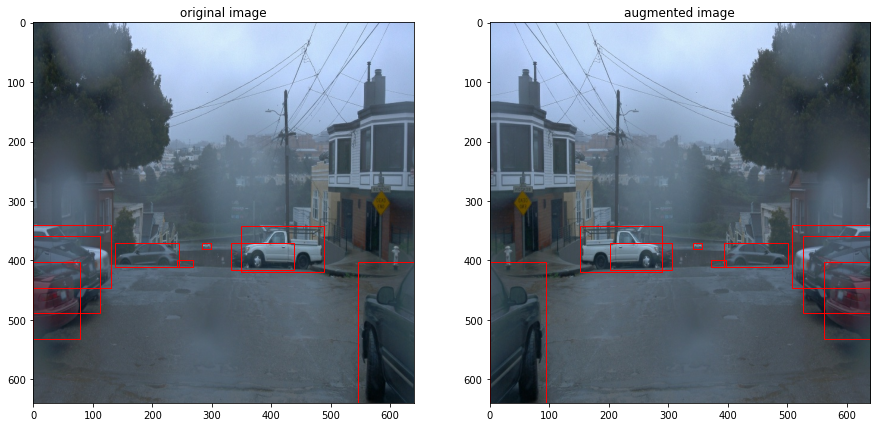

In [71]:
augmentation = [(preprocessor.random_horizontal_flip, {"probability": 1.0})]
augmented_image, augmented_boxes, augmented_classes = display_instance_augmentation(image, bboxes, classes, augmentation, class_color_ind)

### Random RGBtoGray


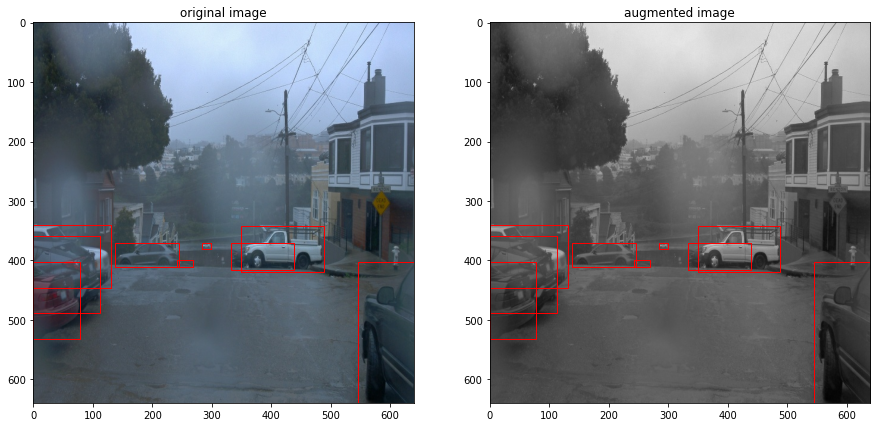

In [72]:
augmentation = [(preprocessor.random_rgb_to_gray, {"probability": 1.0})]
augmented_image, augmented_boxes, augmented_classes = display_instance_augmentation(image, bboxes, classes, augmentation, class_color_ind)

### Random Adjust Brightess

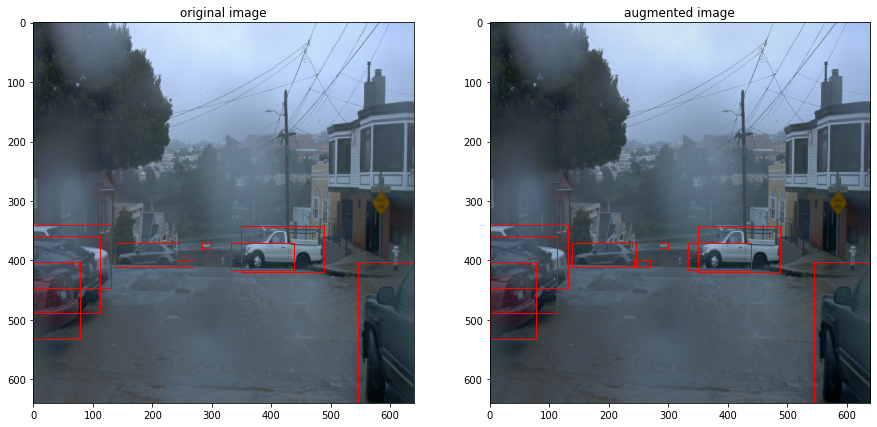

In [81]:
augmentation = [(preprocessor.random_adjust_brightness, {"max_delta": .3})]
augmented_image, augmented_boxes, augmented_classes = display_instance_augmentation(image, bboxes, classes, augmentation, class_color_ind)

### Random Adjust Hue

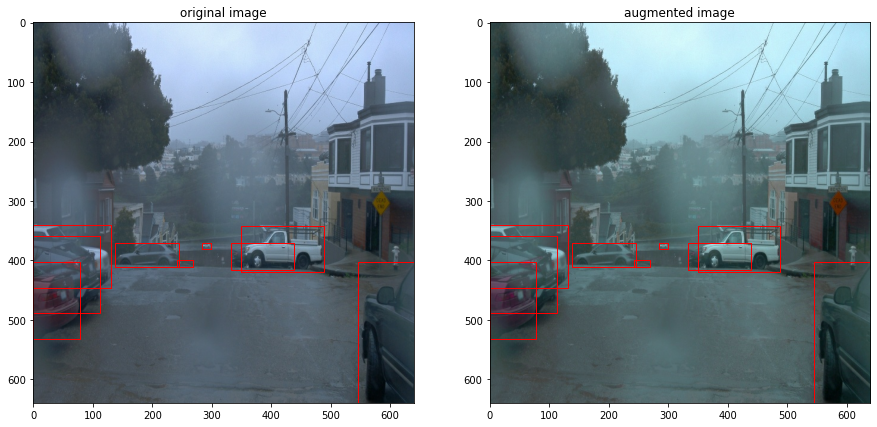

In [86]:
augmentation = [(preprocessor.random_adjust_hue, {"max_delta": .08})]
augmented_image, augmented_boxes, augmented_classes = display_instance_augmentation(image, bboxes, classes, augmentation, class_color_ind)

### Random Adjust Saturation

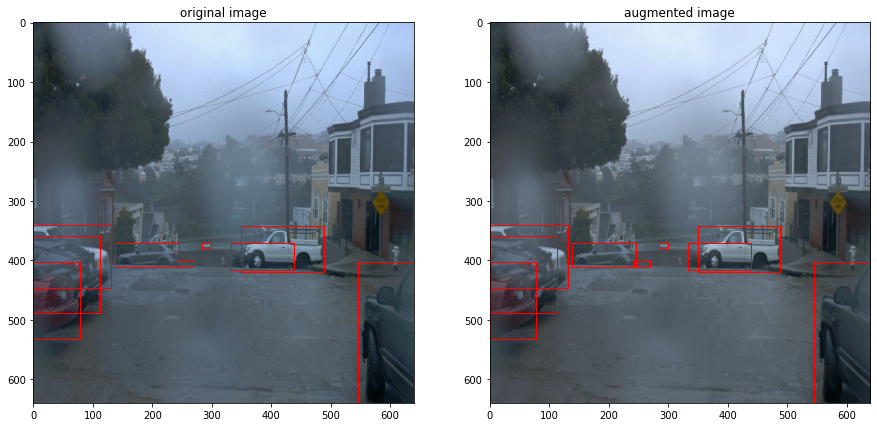

In [88]:
augmentation = [(preprocessor.random_adjust_saturation, {"min_delta": .8, "max_delta": 1.25})]
augmented_image, augmented_boxes, augmented_classes = display_instance_augmentation(image, bboxes, classes, augmentation, class_color_ind)

### Random Jitter Boxes

In [95]:
augmentation = [(preprocessor.random_jitter_boxes, {"ratio":.15, "jitter_mode": 'default'}),]
augmented_image, augmented_boxes, augmented_classes = display_instance_augmentation(image, bboxes, 
                                                                        classes, augmentation, class_color_ind)

TypeError: random_jitter_boxes() got an unexpected keyword argument 'jitter_mode'

### Random Crop

Instructions for updating:
`seed2` arg is deprecated.Use sample_distorted_bounding_box_v2 instead.


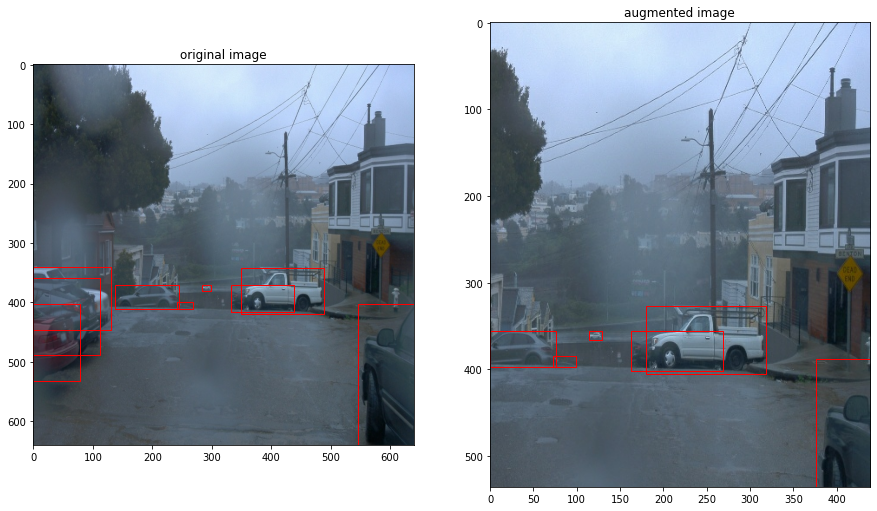

In [97]:
augmentation = [(preprocessor.random_crop_image, 
                 {"min_object_covered":0.0, 
                  "aspect_ratio_range": (0.75,1.33),
                  "area_range": (.1, 1.0),
                  "overlap_thresh": .3,
                  "clip_boxes": True, 
                  "random_coef": 0.0
                  
                 }),]
augmented_image, augmented_boxes, augmented_classes = display_instance_augmentation(image, bboxes, 
                                                                        classes, augmentation, class_color_ind)

### Randomly Crop and Pad

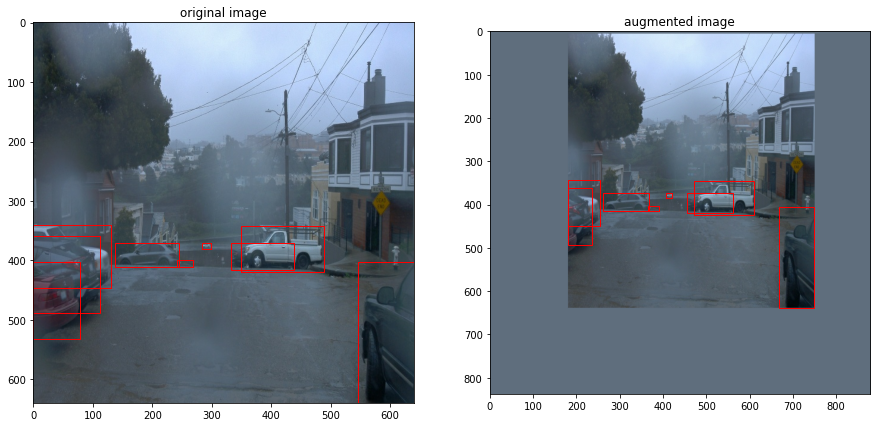

In [102]:
augmentation = [(preprocessor.random_crop_pad_image, 
                 {"min_object_covered":0.25, 
                  "aspect_ratio_range": (0.75,1.33),
                  "area_range": (.1, 1.0),
                  "overlap_thresh": .3,
                  "clip_boxes": True, 
                  "random_coef": 0.0,
                  "min_padded_size_ratio": (.1,.1),
                  "max_padded_size_ratio": (1.5, 1.5)
                 }),]
augmented_image, augmented_boxes, augmented_classes = display_instance_augmentation(image, bboxes, 
                                                                        classes, augmentation, class_color_ind)

### Random Black Patches

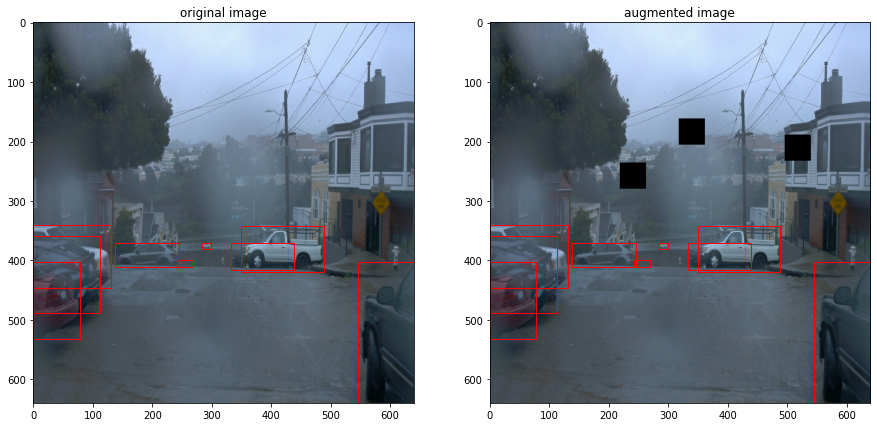

In [106]:
augmentation = [(preprocessor.random_black_patches, {
    "max_black_patches": 8,
    "probability": .5,
    "size_to_image_ratio": .07
})]
augmented_image, augmented_boxes, augmented_classes = display_instance_augmentation(image, bboxes, classes, augmentation, class_color_ind)